In [1]:
import dill as dill
from os import listdir
from os.path import isfile, join
from fall_2021_projection_utils import aggregate_trajs, compute_log_likelihood_by_week, ACTUAL_TRAJ
import sklearn 
from sklearn.preprocessing import PolynomialFeatures

path = "fall_2021_prior_samples:1633381945"
files = [f for f in listdir(path) if isfile(join(path, f)) and 'with_trajectories' in f ]



In [2]:
from vax_sims_LHS_samples import *

In [3]:
sampled_points = {}
aggregated_trajs = {}

count = 0
for f in files:
    with open(join(path, f), "rb") as fhandle:
        [point, inf_trajs_by_group] = dill.load(fhandle)
        sampled_points[f] = point
        aggregated_trajs[f] = aggregate_trajs(inf_trajs_by_group)
    count += 1
    if count % 10 == 0:
        print("Loaded {} points".format(count))
    
        
        

Loaded 10 points
Loaded 20 points
Loaded 30 points
Loaded 40 points
Loaded 50 points
Loaded 60 points
Loaded 70 points
Loaded 80 points
Loaded 90 points
Loaded 100 points
Loaded 110 points
Loaded 120 points
Loaded 130 points
Loaded 140 points
Loaded 150 points
Loaded 160 points
Loaded 170 points
Loaded 180 points
Loaded 190 points
Loaded 200 points
Loaded 210 points
Loaded 220 points
Loaded 230 points
Loaded 240 points
Loaded 250 points
Loaded 260 points
Loaded 270 points
Loaded 280 points
Loaded 290 points
Loaded 300 points
Loaded 310 points
Loaded 320 points
Loaded 330 points
Loaded 340 points
Loaded 350 points
Loaded 360 points
Loaded 370 points
Loaded 380 points
Loaded 390 points
Loaded 400 points
Loaded 410 points
Loaded 420 points
Loaded 430 points
Loaded 440 points
Loaded 450 points
Loaded 460 points
Loaded 470 points
Loaded 480 points
Loaded 490 points
Loaded 500 points
Loaded 510 points
Loaded 520 points
Loaded 530 points
Loaded 540 points
Loaded 550 points
Loaded 560 points
L

In [4]:
len(sampled_points)

1000

In [5]:
from fall_2021_projection_utils import get_positives_by_week, get_true_positives_by_week
from scipy.stats import poisson
def compute_log_likelihood_by_week_(simulated_cumulative_trajs, eps=1e-5):
    simulated_positives_by_week = get_positives_by_week(simulated_cumulative_trajs)
    true_positives_by_week = get_true_positives_by_week()
    loglik = 0
    for true_positives, simulated_positives in zip(true_positives_by_week, 
                                                   simulated_positives_by_week):                                                    
        loglik += np.log(poisson.pmf(true_positives, simulated_positives) + eps)
    
    return loglik

In [6]:
import numpy as np
logliks = {}
for f in sampled_points:
    logliks[f] = compute_log_likelihood_by_week_(aggregated_trajs[f], eps=0)

/home/yz685/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


Text(0, 0.5, 'number of cases')

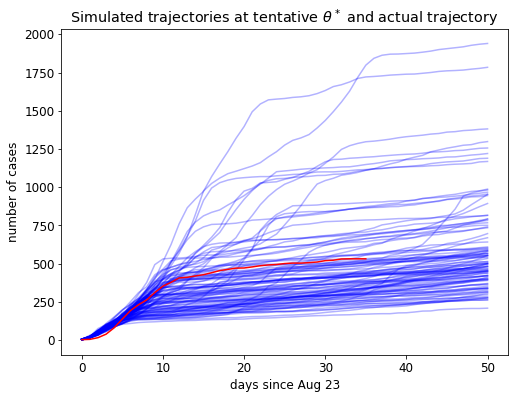

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
for i in range(len(aggregated_trajs['point_456_with_trajectories.dill'])):
    plt.plot(aggregated_trajs['point_456_with_trajectories.dill'][i], color='b', alpha=0.3)
plt.plot(np.cumsum(np.array(ACTUAL_TRAJ)), color='r')
plt.title(r'Simulated trajectories at tentative $\theta^*$ and actual trajectory')
plt.xlabel('days since Aug 23')
plt.ylabel('number of cases')

In [8]:
from fall_2021_projection_utils import UNCERTAINTY_PARAMS

param_vals = {}
param_logliks = {}

for idx, param in enumerate(UNCERTAINTY_PARAMS):
    param_vals[param] = []
    param_logliks[param] = []
    for f in sampled_points:
        param_vals[param].append(sampled_points[f][idx]) # sampled parameter values
        param_logliks[param].append(logliks[f]) # log likelihood for corresponding param value
    

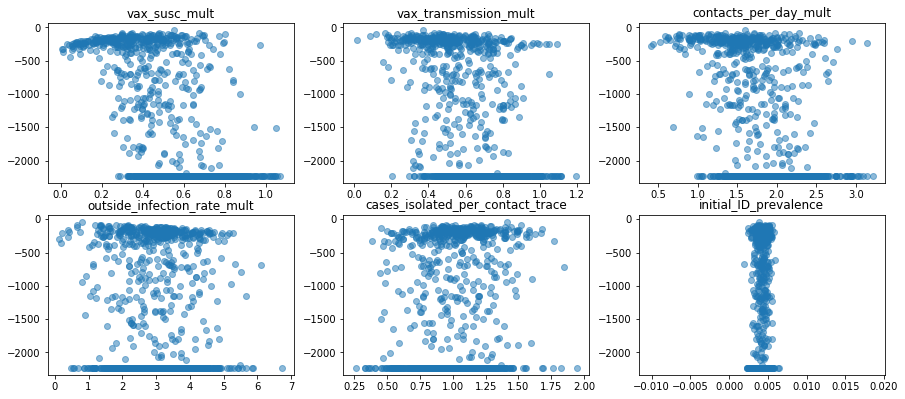

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(15,10))

for idx, param in enumerate(UNCERTAINTY_PARAMS):
    min_val = min([x for x in param_logliks[param] if x != float('-inf')])

    plt.subplot(3,3,idx+1)
    plt.scatter(param_vals[param], 
                [x if x != float('-inf') else min_val for x in param_logliks[param]],
               alpha=0.5)
    #plt.xlabel("Parameter Value")
    #plt.ylabel("Estimated Log Likelihood")
    plt.title("{}".format(param))

/home/yz685/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log
/home/yz685/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log


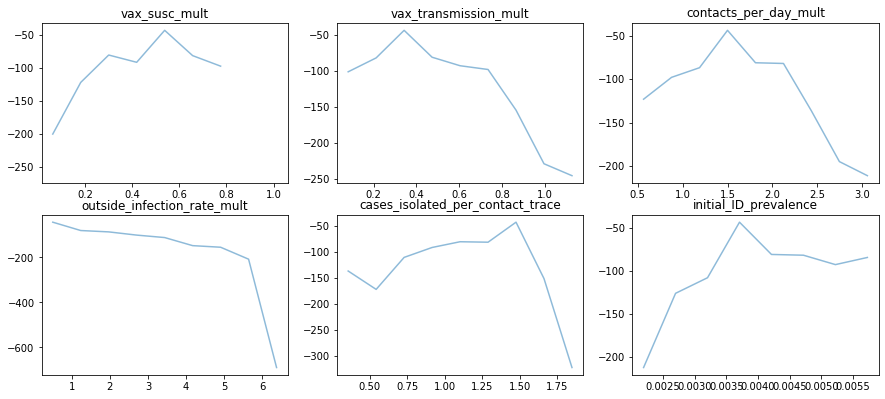

In [10]:
def estimate_marginal_dist(param_vals, logliks):
    bin_boundaries = np.linspace(min(param_vals), max(param_vals), num=10)
    num_bins = len(bin_boundaries) - 1
    bin_centres = []
    bin_likelihoods = []
    for bin_start_idx in range((num_bins)):
        bin_start_val = bin_boundaries[bin_start_idx]
        bin_end_val = bin_boundaries[bin_start_idx + 1]
        bin_centres.append(0.5 * (bin_start_val + bin_end_val))
        
        if bin_end_val == max(param_vals):
            bin_end_val += 1
        likelihoods = [np.exp(loglik) for (param_val, loglik) in zip(param_vals, logliks)
                      if param_val >= bin_start_val and param_val < bin_end_val and 
                      loglik != float('-inf')]
        
        avg_lik = np.log(np.sum(likelihoods))
        bin_likelihoods.append(avg_lik)
    return bin_centres, bin_likelihoods
        

plt.figure(figsize=(15,10))

for idx, param in enumerate(UNCERTAINTY_PARAMS):

    plt.subplot(3,3,idx+1)
    centres, likelihoods = estimate_marginal_dist(param_vals[param], param_logliks[param])
    plt.plot(centres, 
                likelihoods,
               alpha=0.5)
    #plt.xlabel("Parameter Value")
    #plt.ylabel("Estimated Log Likelihood")
    plt.title("{}".format(param))

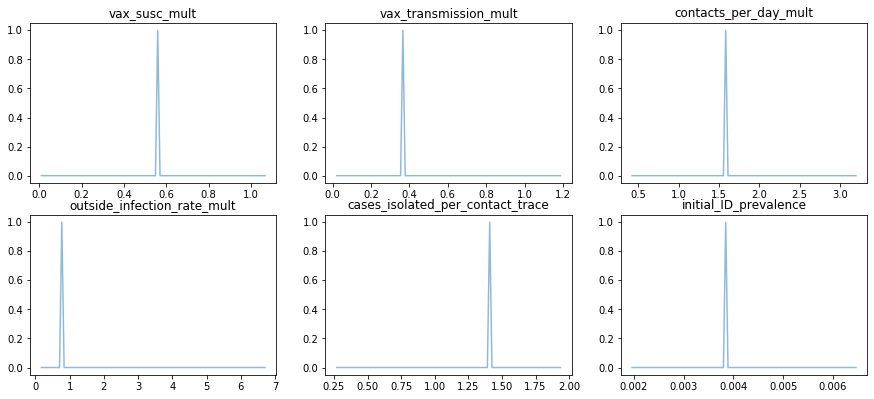

In [11]:
def estimate_marginal_dist(param_vals, logliks):
    bin_boundaries = np.linspace(min(param_vals), max(param_vals), num=100)
    num_bins = len(bin_boundaries) - 1
    bin_centres = []
    bin_likelihoods = []
    for bin_start_idx in range((num_bins)):
        bin_start_val = bin_boundaries[bin_start_idx]
        bin_end_val = bin_boundaries[bin_start_idx + 1]
        bin_centres.append(0.5 * (bin_start_val + bin_end_val))
        
        if bin_end_val == max(param_vals):
            bin_end_val += 1
        likelihoods = [np.exp(loglik - np.max(logliks)) for (param_val, loglik) in zip(param_vals, logliks)
                      if param_val >= bin_start_val and param_val < bin_end_val and 
                      loglik != float('-inf')]
        
        avg_lik = np.sum(likelihoods)
        bin_likelihoods.append(avg_lik)
    return bin_centres, bin_likelihoods
        

plt.figure(figsize=(15,10))

for idx, param in enumerate(UNCERTAINTY_PARAMS):

    plt.subplot(3,3,idx+1)
    centres, likelihoods = estimate_marginal_dist(param_vals[param], param_logliks[param])
    plt.plot(centres, 
                likelihoods,
               alpha=0.5)
    #plt.xlabel("Parameter Value")
    #plt.ylabel("Estimated Log Likelihood")
    plt.title("{}".format(param))

Text(0.5, 1.0, 'distribution of log likelihoods using weekly aggregation')

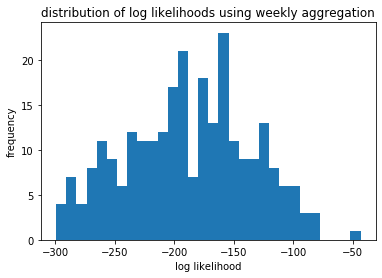

In [12]:
plt.hist([x for x in param_logliks[UNCERTAINTY_PARAMS[0]] 
          if x != float('-inf') and x >= -300], bins=30)
plt.xlabel("log likelihood")
plt.ylabel("frequency")
plt.title("distribution of log likelihoods using weekly aggregation")

In [13]:
import pandas as pd
df = pd.DataFrame(param_vals)
df['log_likelihood'] = param_logliks[UNCERTAINTY_PARAMS[0]]
df['combined_spread_mult'] = df['vax_transmission_mult'] * df['vax_susc_mult'] * \
                                      df['contacts_per_day_mult']
min_loglik = min(df[df['log_likelihood'] > -np.inf]['log_likelihood'])
df.replace(-np.inf, min_loglik, inplace=True)
df['file_name'] = sampled_points
df.shape

(1000, 9)

In [48]:
# find entry with the largest log likelihood
df['log_likelihood'].idxmax() 

395

In [14]:
subdf_diff = df[['outside_infection_rate_mult', \
               'cases_isolated_per_contact_trace', \
               'initial_ID_prevalence', \
               'combined_spread_mult', \
               'log_likelihood']]

subdf_diff.sub(subdf_diff.iloc[395])

,outside_infection_rate_mult,cases_isolated_per_contact_trace,initial_ID_prevalence,combined_spread_mult,log_likelihood
0,1.715183,-0.349834,0.002628,0.324016,-2184.098190
1,2.882706,-0.882448,-0.000427,0.218801,-2184.098190
2,1.862187,-0.944001,-0.000198,0.000315,-362.283670
3,5.044409,-0.619824,0.000127,0.664666,-2184.098190
4,1.205466,-0.185378,0.000438,0.131287,-372.202591
...,...,...,...,...,...
995,1.290061,-0.146546,-0.000185,0.125430,-333.114396
996,1.318142,-0.316847,0.001465,0.507900,-2184.098190
997,1.737879,-0.758557,0.000570,0.147250,-2184.098190
998,1.657635,-0.960941,-0.000055,0.586468,-2184.098190


In [15]:
params_diff = subdf_diff[['outside_infection_rate_mult', \
               'cases_isolated_per_contact_trace', \
               'initial_ID_prevalence', \
               'combined_spread_mult']]
loglik_diff = subdf_diff['log_likelihood']
quadratic = PolynomialFeatures(degree = 2,interaction_only=False,include_bias = False)



In [16]:
params_diff

,outside_infection_rate_mult,cases_isolated_per_contact_trace,initial_ID_prevalence,combined_spread_mult
0,2.515498,1.065157,0.006487,0.651268
1,3.683021,0.532544,0.003432,0.546052
2,2.662501,0.470991,0.003662,0.327567
3,5.844724,0.795168,0.003987,0.991918
4,2.005781,1.229614,0.004297,0.458539
...,...,...,...,...
995,2.090376,1.268446,0.003674,0.452682
996,2.118457,1.098145,0.005324,0.835152
997,2.538194,0.656435,0.004430,0.474502
998,2.457950,0.454051,0.003804,0.913720


In [26]:
params_diff_quadratic = pd.DataFrame(quadratic.fit_transform(params_diff.to_numpy()),\
                                     columns = quadratic.get_feature_names(params_diff.columns))
params_diff_quadratic

,outside_infection_rate_mult,cases_isolated_per_contact_trace,initial_ID_prevalence,combined_spread_mult,outside_infection_rate_mult^2,outside_infection_rate_mult cases_isolated_per_contact_trace,outside_infection_rate_mult initial_ID_prevalence,outside_infection_rate_mult combined_spread_mult,cases_isolated_per_contact_trace^2,cases_isolated_per_contact_trace initial_ID_prevalence,cases_isolated_per_contact_trace combined_spread_mult,initial_ID_prevalence^2,initial_ID_prevalence combined_spread_mult,combined_spread_mult^2
0,2.515498,1.065157,0.006487,0.651268,6.327729,2.679401,0.016318,1.638262,1.134560,0.006910,0.693702,0.000042,0.004225,0.424149
1,3.683021,0.532544,0.003432,0.546052,13.564645,1.961372,0.012641,2.011122,0.283603,0.001828,0.290797,0.000012,0.001874,0.298173
2,2.662501,0.470991,0.003662,0.327567,7.088914,1.254015,0.009749,0.872147,0.221833,0.001725,0.154281,0.000013,0.001199,0.107300
3,5.844724,0.795168,0.003987,0.991918,34.160798,4.647536,0.023301,5.797484,0.632292,0.003170,0.788741,0.000016,0.003954,0.983900
4,2.005781,1.229614,0.004297,0.458539,4.023157,2.466336,0.008618,0.919728,1.511951,0.005283,0.563826,0.000018,0.001970,0.210258
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,2.090376,1.268446,0.003674,0.452682,4.369672,2.651529,0.007680,0.946275,1.608955,0.004660,0.574203,0.000013,0.001663,0.204921
996,2.118457,1.098145,0.005324,0.835152,4.487860,2.326374,0.011279,1.769233,1.205923,0.005847,0.917118,0.000028,0.004447,0.697478
997,2.538194,0.656435,0.004430,0.474502,6.442430,1.666160,0.011243,1.204378,0.430907,0.002908,0.311480,0.000020,0.002102,0.225152
998,2.457950,0.454051,0.003804,0.913720,6.041518,1.116034,0.009351,2.245878,0.206162,0.001727,0.414875,0.000014,0.003476,0.834884


In [27]:
from statsmodels.api import OLS, add_constant
model = OLS(loglik_diff, params_diff_quadratic/ params_diff_quadratic.max())
results = model.fit()



In [29]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:         log_likelihood   R-squared (uncentered):                   0.942
Model:                            OLS   Adj. R-squared (uncentered):              0.941
Method:                 Least Squares   F-statistic:                              1137.
Date:                Tue, 05 Oct 2021   Prob (F-statistic):                        0.00
Time:                        21:07:58   Log-Likelihood:                         -7431.5
No. Observations:                1000   AIC:                                  1.489e+04
Df Residuals:                     986   BIC:                                  1.496e+04
Df Model:                          14                                                  
Covariance Type:            nonrobust                                                  
================================================================================================================================
                                                                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------------
outside_infection_rate_mult                                  -1096.3358    696.837     -1.573      0.116   -2463.791     271.119
cases_isolated_per_contact_trace                              2722.1107    719.751      3.782      0.000    1309.692    4134.530
initial_ID_prevalence                                         -176.2005    691.198     -0.255      0.799   -1532.589    1180.188
combined_spread_mult                                         -1.217e+04    753.760    -16.142      0.000   -1.36e+04   -1.07e+04
outside_infection_rate_mult^2                                  502.3300    418.349      1.201      0.230    -318.627    1323.288
outside_infection_rate_mult cases_isolated_per_contact_trace  -545.1857    409.549     -1.331      0.183   -1348.873     258.502
outside_infection_rate_mult initial_ID_prevalence              654.9476    661.179      0.991      0.322    -642.533    1952.428
outside_infection_rate_mult combined_spread_mult               681.5946    338.715      2.012      0.044      16.910    1346.279
cases_isolated_per_contact_trace^2                            -307.2206    519.466     -0.591      0.554   -1326.607     712.166
cases_isolated_per_contact_trace initial_ID_prevalence        -779.6492    722.312     -1.079      0.281   -2197.095     637.797
cases_isolated_per_contact_trace combined_spread_mult        -1252.6915    491.097     -2.551      0.011   -2216.407    -288.976
initial_ID_prevalence^2                                        244.3226    797.730      0.306      0.759   -1321.120    1809.765
initial_ID_prevalence combined_spread_mult                     122.4892    742.086      0.165      0.869   -1333.761    1578.739
combined_spread_mult^2                                         1.19e+04    415.278     28.653      0.000    1.11e+04    1.27e+04
==============================================================================
Omnibus:                       37.427   Durbin-Watson:                   2.027
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               41.258
Skew:                          -0.458   Prob(JB):                     1.10e-09
Kurtosis:                       3.388   Cond. No.                         131.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [30]:
results.params

outside_infection_rate_mult                                     -1096.335848
cases_isolated_per_contact_trace                                 2722.110727
initial_ID_prevalence                                            -176.200458
combined_spread_mult                                           -12167.372890
outside_infection_rate_mult^2                                     502.330043
outside_infection_rate_mult cases_isolated_per_contact_trace     -545.185654
outside_infection_rate_mult initial_ID_prevalence                 654.947590
outside_infection_rate_mult combined_spread_mult                  681.594607
cases_isolated_per_contact_trace^2                               -307.220561
cases_isolated_per_contact_trace initial_ID_prevalence           -779.649233
cases_isolated_per_contact_trace combined_spread_mult           -1252.691542
initial_ID_prevalence^2                                           244.322591
initial_ID_prevalence combined_spread_mult                        122.489177

In [34]:
unnorm_coef = results.params / params_diff_quadratic.max()

In [36]:
unnorm_coef

outside_infection_rate_mult                                    -1.626979e+02
cases_isolated_per_contact_trace                                1.400320e+03
initial_ID_prevalence                                          -2.716261e+04
combined_spread_mult                                           -5.060593e+03
outside_infection_rate_mult^2                                   1.106282e+01
outside_infection_rate_mult cases_isolated_per_contact_trace   -6.670687e+01
outside_infection_rate_mult initial_ID_prevalence               1.991958e+04
outside_infection_rate_mult combined_spread_mult                7.947368e+01
cases_isolated_per_contact_trace^2                             -8.130055e+01
cases_isolated_per_contact_trace initial_ID_prevalence         -7.825937e+04
cases_isolated_per_contact_trace combined_spread_mult          -3.636231e+02
initial_ID_prevalence^2                                         5.806208e+06
initial_ID_prevalence combined_spread_mult                      1.016978e+04

In [45]:
# map regression results to hessian matrix

hessian = np.zeros((4,4))

counter = 0
for i in range(4):
    for j in range(i, 4):
        if i == j:
            hessian[i,j] = -2 * unnorm_coef[4+counter]
        else:
            hessian[i,j] = -unnorm_coef[4+counter]
        counter += 1

# fill in symmetric lower triangular part
for i in range(1,4):
    for j in range(i):
        hessian[i,j] = hessian[j,i]
    
print(hessian)

[[-2.21256332e+01  6.67068672e+01 -1.99195753e+04 -7.94736802e+01]
 [ 6.67068672e+01  1.62601101e+02  7.82593733e+04  3.63623055e+02]
 [-1.99195753e+04  7.82593733e+04 -1.16124158e+07 -1.01697812e+04]
 [-7.94736802e+01  3.63623055e+02 -1.01697812e+04 -4.11666449e+03]]


In [47]:
np.linalg.eig(hessian)

(array([-1.16129862e+07,  5.63439950e+00,  7.15277479e+02, -4.12663904e+03]),
 array([[-1.71529035e-03, -9.94805133e-01,  1.00821029e-01,
          1.39615348e-02],
        [ 6.73873084e-03, -1.01499341e-01, -9.92944475e-01,
         -6.09404926e-02],
        [-9.99975439e-01,  1.01566328e-03, -6.80992098e-03,
         -1.30916367e-03],
        [-8.76236744e-04,  7.72002522e-03, -6.20484925e-02,
          9.98042894e-01]]))

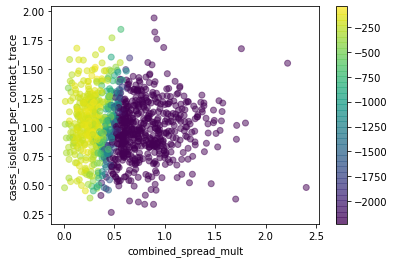

In [18]:
plt.scatter(df['combined_spread_mult'], df['cases_isolated_per_contact_trace'],
           c=df['log_likelihood'], alpha=0.5)
plt.xlabel('combined_spread_mult')
plt.ylabel('cases_isolated_per_contact_trace')
plt.colorbar()

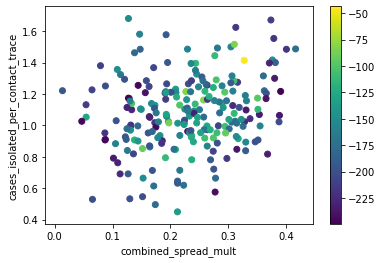

In [19]:
subdf = df[df['log_likelihood'] >= -250]
plt.scatter(subdf['combined_spread_mult'], subdf['cases_isolated_per_contact_trace'],
           c=subdf['log_likelihood'])
plt.xlabel('combined_spread_mult')
plt.ylabel('cases_isolated_per_contact_trace')
plt.colorbar()

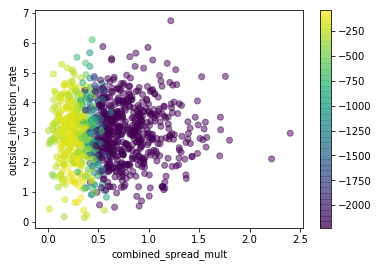

In [34]:
plt.scatter(df['combined_spread_mult'], df['outside_infection_rate_mult'],
           c=df['log_likelihood'], alpha=0.5)
plt.xlabel('combined_spread_mult')
plt.ylabel('outside_infection_rate')
plt.colorbar()
plt.show()



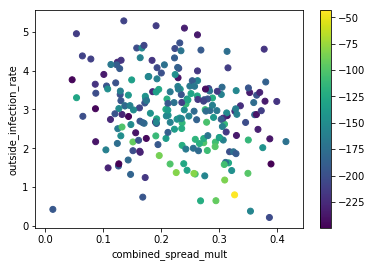

In [35]:
plt.scatter(subdf['combined_spread_mult'], subdf['outside_infection_rate_mult'],
           c=subdf['log_likelihood'])
plt.xlabel('combined_spread_mult')
plt.ylabel('outside_infection_rate')
plt.colorbar()